#### Modules

In [1]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import mean, desc, col, stddev, min, max, expr
from pyspark.sql.types import IntegerType
# from pyspark.ml.feature import StandardScaler, VectorAssembler, CountVectorizer
# from pyspark.ml.clustering import KMeans
# from pyspark.ml.evaluation import ClusteringEvaluator
# from pyspark.ml.stat import Correlation
# import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import networkx as nx

#### Session Spark

In [2]:
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("Twitch_Networks.com") \
    .getOrCreate()

22/07/22 10:43:14 WARN Utils: Your hostname, ELISABETH-PERSO resolves to a loopback address: 127.0.1.1; using 10.33.4.168 instead (on interface wlp1s0)
22/07/22 10:43:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/22 10:43:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Import des CSVs depuis le serveur HDFS

In [3]:
df_top = spark.read.csv("hdfs://127.0.0.1:9000/esgi/data/projets/final/twitchdata-update.csv", 
                           header='true')
df_edges = spark.read.csv("hdfs://127.0.0.1:9000/esgi/data/projets/final/EDGELIST.csv", 
                           header='true')

#### cast des colonnes de string à int

In [4]:
df_top = df_top.withColumn("Followers",col("Followers").cast("integer"))
df_top = df_top.withColumn("Peak viewers",col("Peak viewers").cast("integer"))
df_top = df_top.withColumn("Average viewers",col("Average viewers").cast("integer"))
df_top = df_top.withColumn("Watch time(Minutes)",col("Watch time(Minutes)").cast("integer"))
df_top = df_top.withColumn("Stream time(minutes)",col("Stream time(minutes)").cast("integer"))
df_top = df_top.withColumn("Followers gained",col("Followers gained").cast("integer"))
df_top = df_top.withColumn("Views gained",col("Views gained").cast("integer"))
df_edges = df_edges.withColumn("Weight",col("Weight").cast("integer"))

### Dataset Edge List

Ce dataset associe un compte Source à un compte Target. Chaque association a un poids Weight, qui corespond au nombre d'abonnés donnés.

In [5]:
df_edges.limit(5).toPandas()

,Source,Target,Weight
0,Send0o,elded,507
1,Send0o,riotgames,4525
2,Send0o,NickDaBooM,1787
3,Send0o,PapoMC,1551
4,Send0o,ReventXz,6675


#### Comptes qui ont reçu le plus d'abonnés

In [6]:
df_edges.groupBy("Target").sum("Weight").sort(desc("sum(Weight)")).limit(10).toPandas()

,Target,sum(Weight)
0,loltyler1,7841740
1,summit1g,6977193
2,ludwig,6557522
3,tommyinnit,5867582
4,xQcOW,5857641
5,Asmongold,5815087
6,Indiefoxx,5669729
7,NICKMERCS,5514463
8,auronplay,5231721
9,Trainwreckstv,4545824


#### Comptes qui ont donné le plus d'abonnés

In [7]:
df_edges.groupBy("Source").sum("Weight").sort(desc("sum(Weight)")).limit(10).toPandas()

,Source,sum(Weight)
0,shroud,12496693
1,xQcOW,11880565
2,Amouranth,9753150
3,riotgames,8940507
4,ibai,8831061
5,Mizkif,8237345
6,sodapoppin,6382345
7,pokimane,5953182
8,TimTheTatman,5937132
9,RanbooLive,5856675


#### Statistiques

##### du nombre d'abonnés donnés d'un compte à un autre

In [8]:
quantiles = expr('percentile_approx(Weight, array(0.25, 0.5, 0.75))')
df_edges.agg(mean("Weight"), min("Weight"), max("Weight"), quantiles.alias('quantiles')).toPandas()

,avg(Weight),min(Weight),max(Weight),quantiles
0,3422.686185,501,437725,"[701, 1147, 2600]"


##### du nombre d'abonnés total donnés par un compte

In [9]:
quantiles = expr("percentile_approx('sum(Weight)', 0.5)")
df_edges.groupBy("Source").sum("Weight").agg(mean("sum(Weight)"), min("sum(Weight)"), max("sum(Weight)"), quantiles.alias('quantiles')).toPandas()

,avg(sum(Weight)),min(sum(Weight)),max(sum(Weight)),quantiles
0,365601.940167,501,12496693,NaN


### Dataset Top Streamers

Ce dataset donne des informations pour chacun des streamers du top 1000.

In [10]:
df_top.sort(desc("Followers")).limit(5).toPandas()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,Tfue,NaN,123660,285644,29602,8938903,2068424,78998587,True,False,English
1,shroud,8.885052e+08,30240,471281,29612,7744066,833587,30621257,True,False,English
2,Myth,1.479215e+09,134760,122552,9396,6726893,1421811,37384058,True,False,English
3,Rubius,NaN,58275,240096,42948,5751354,3820532,58599449,True,False,Spanish
4,pokimane,9.643341e+08,56505,112160,16026,5367605,2085831,45579002,True,False,English


### Statistiques des followers des top streamers

In [11]:
quantiles = expr('percentile_approx(Followers, array(0.25, 0.5, 0.75))')
df_top.agg(mean("Followers"), min("Followers"), max("Followers"), quantiles.alias('quantiles')).toPandas()

,avg(Followers),min(Followers),max(Followers),quantiles
0,570054.068,3660,8938903,"[170181, 317896, 622358]"


#### Facteurs

In [12]:
total = df_top.count()
print("unpartnered", df_top.filter(col("Partnered") == "False").count()/total, "%")
print("partnered", df_top.filter(col("Partnered") == "True").count()/total, "%")
print("mature", df_top.filter(col("Mature") == "False").count()/total, "%")
print("not mature", df_top.filter(col("Mature") == "True").count()/total, "%")

unpartnered 0.022 %
partnered 0.978 %
mature 0.77 %
not mature 0.23 %


In [13]:
quantiles = expr('percentile_approx(Followers, array(0.25, 0.5, 0.75))')
df_top.filter(col("Partnered") == "False").agg(mean("Followers"), min("Followers"), max("Followers"), quantiles.alias('quantiles')).toPandas()

,avg(Followers),min(Followers),max(Followers),quantiles
0,331942.681818,7102,2115596,"[82570, 146035, 274237]"


In [14]:
df_top.filter(col("Partnered") == "True").agg(mean("Followers"), min("Followers"), max("Followers"), quantiles.alias('quantiles')).toPandas()

,avg(Followers),min(Followers),max(Followers),quantiles
0,575410.356851,3660,8938903,"[173271, 323856, 634982]"


In [37]:
graph = nx.from_pandas_edgelist(df_edges.select("Source","Target").toPandas(), "Source", "Target")

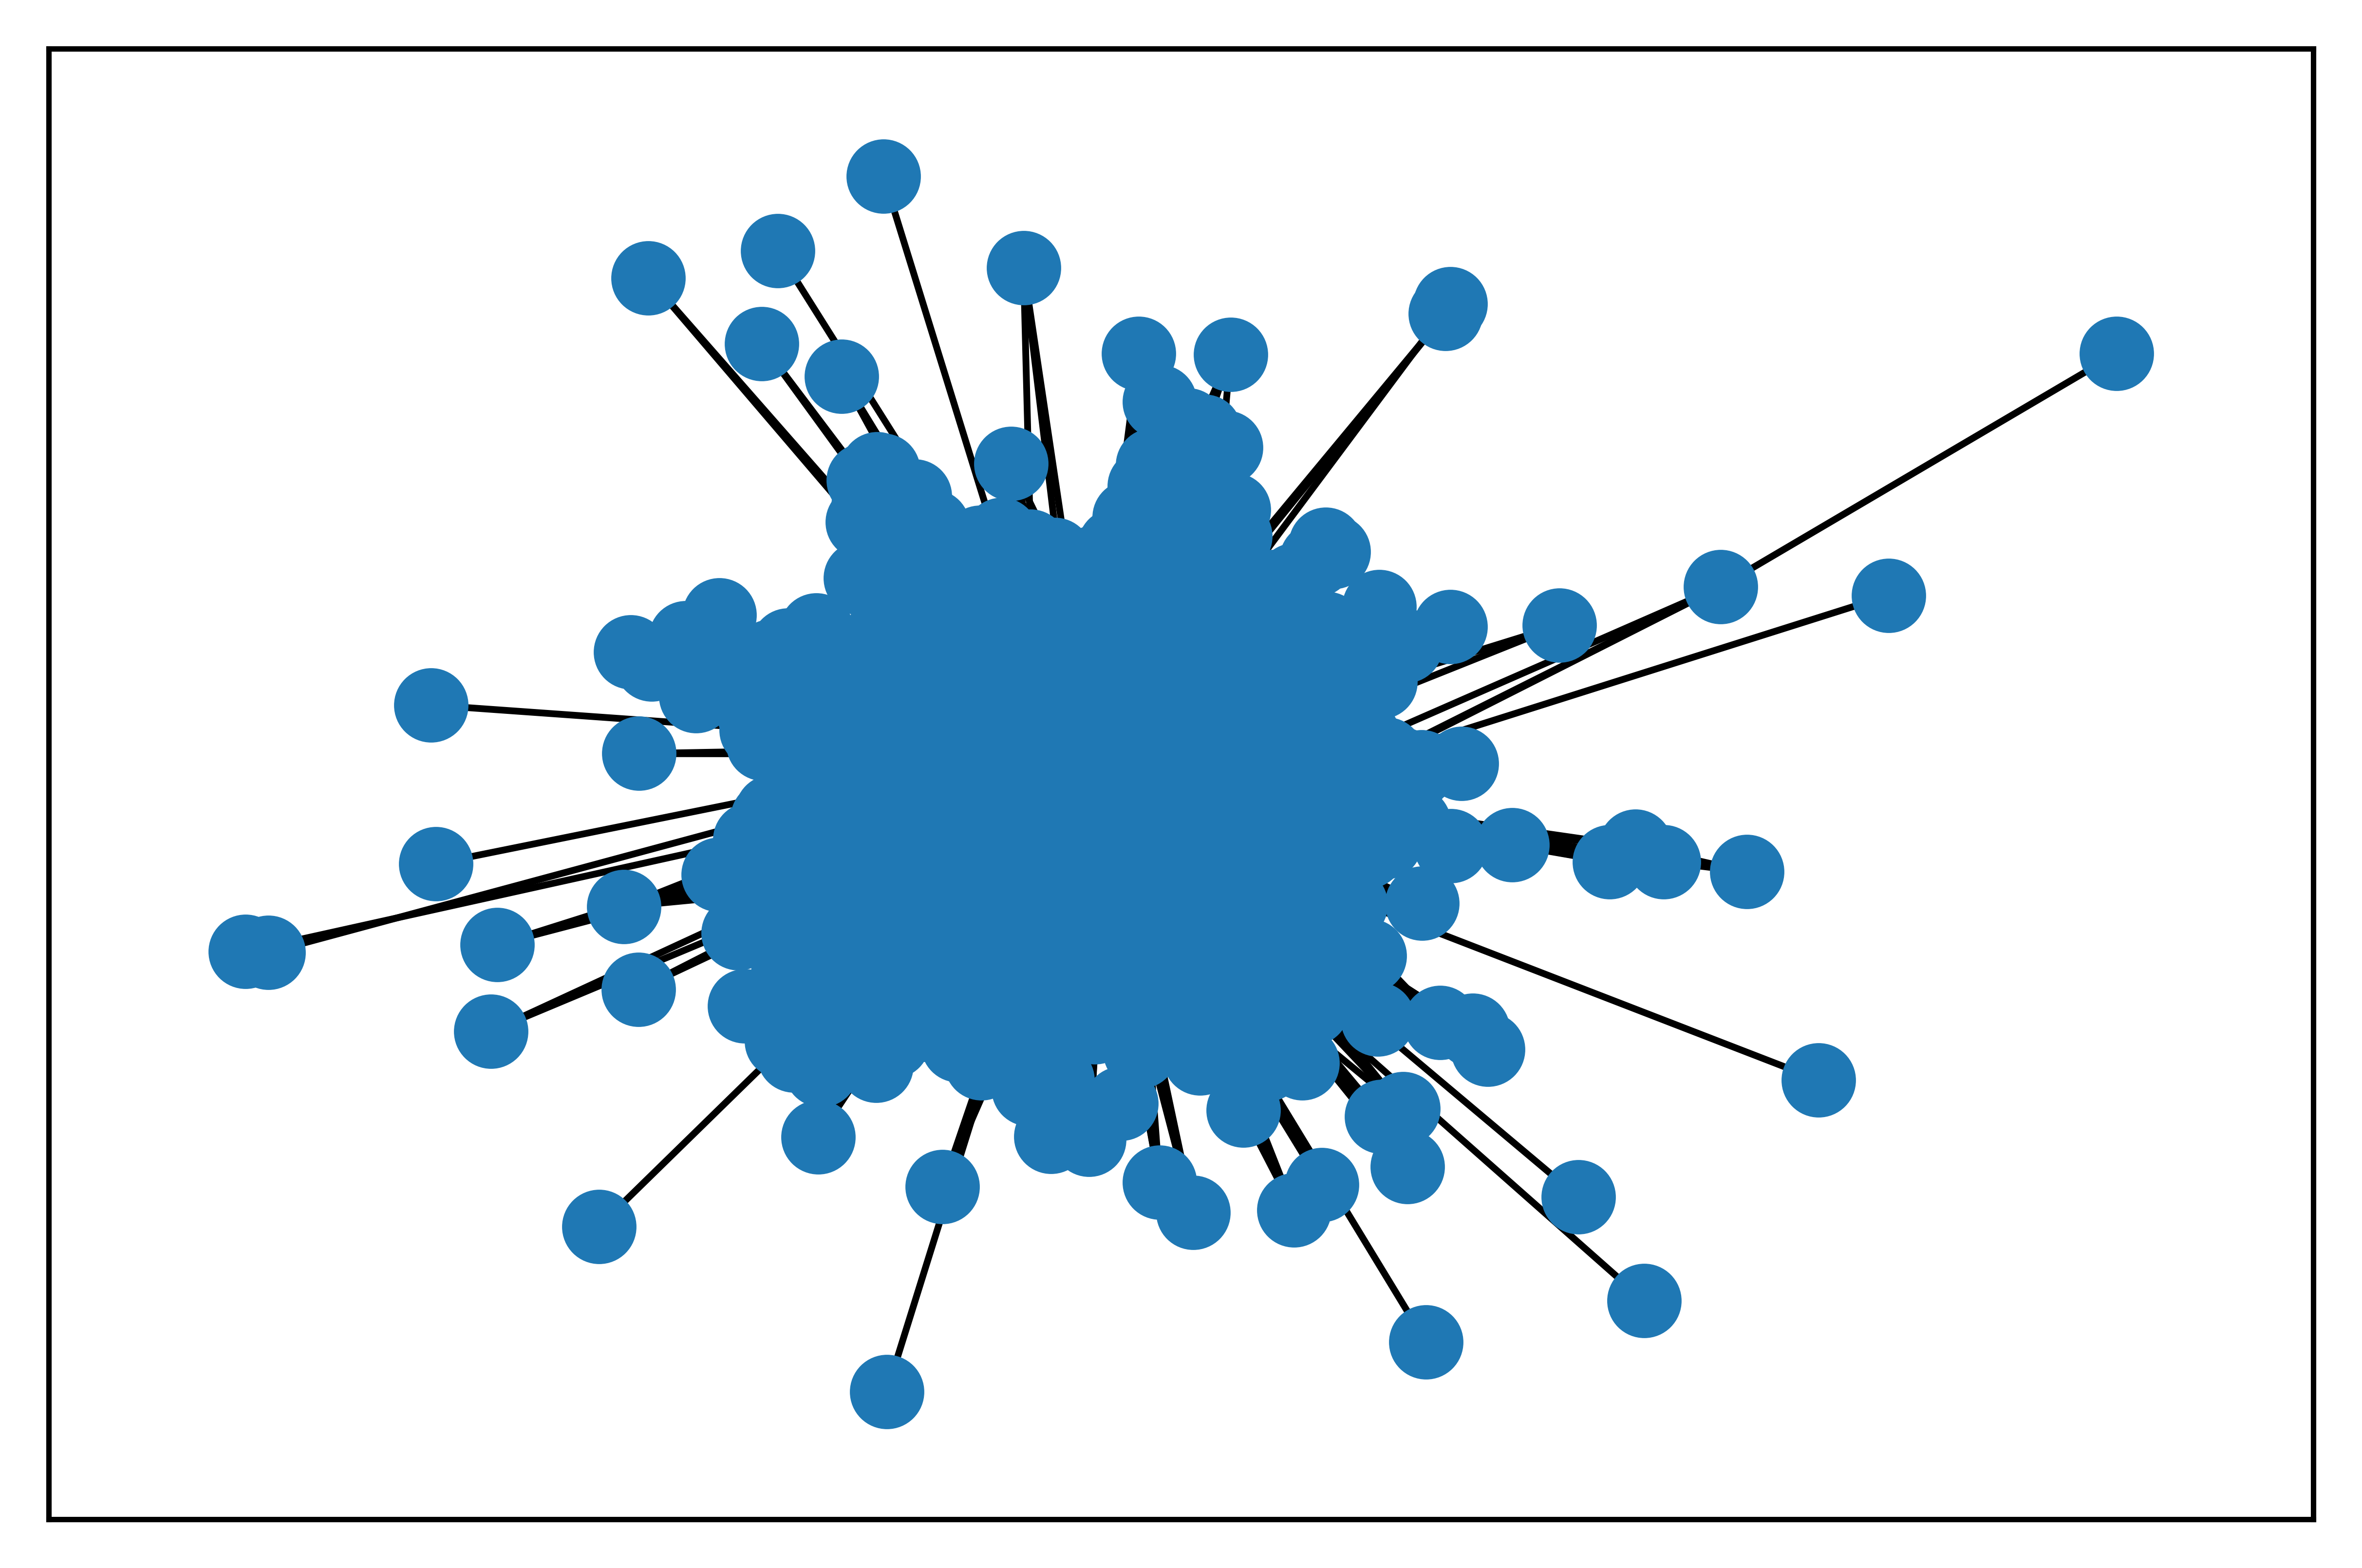

In [40]:
nx.draw_networkx(graph, with_labels=False, font_size=5, node_size=100)
plt.rcParams['figure.dpi'] = 1000
plt.show()

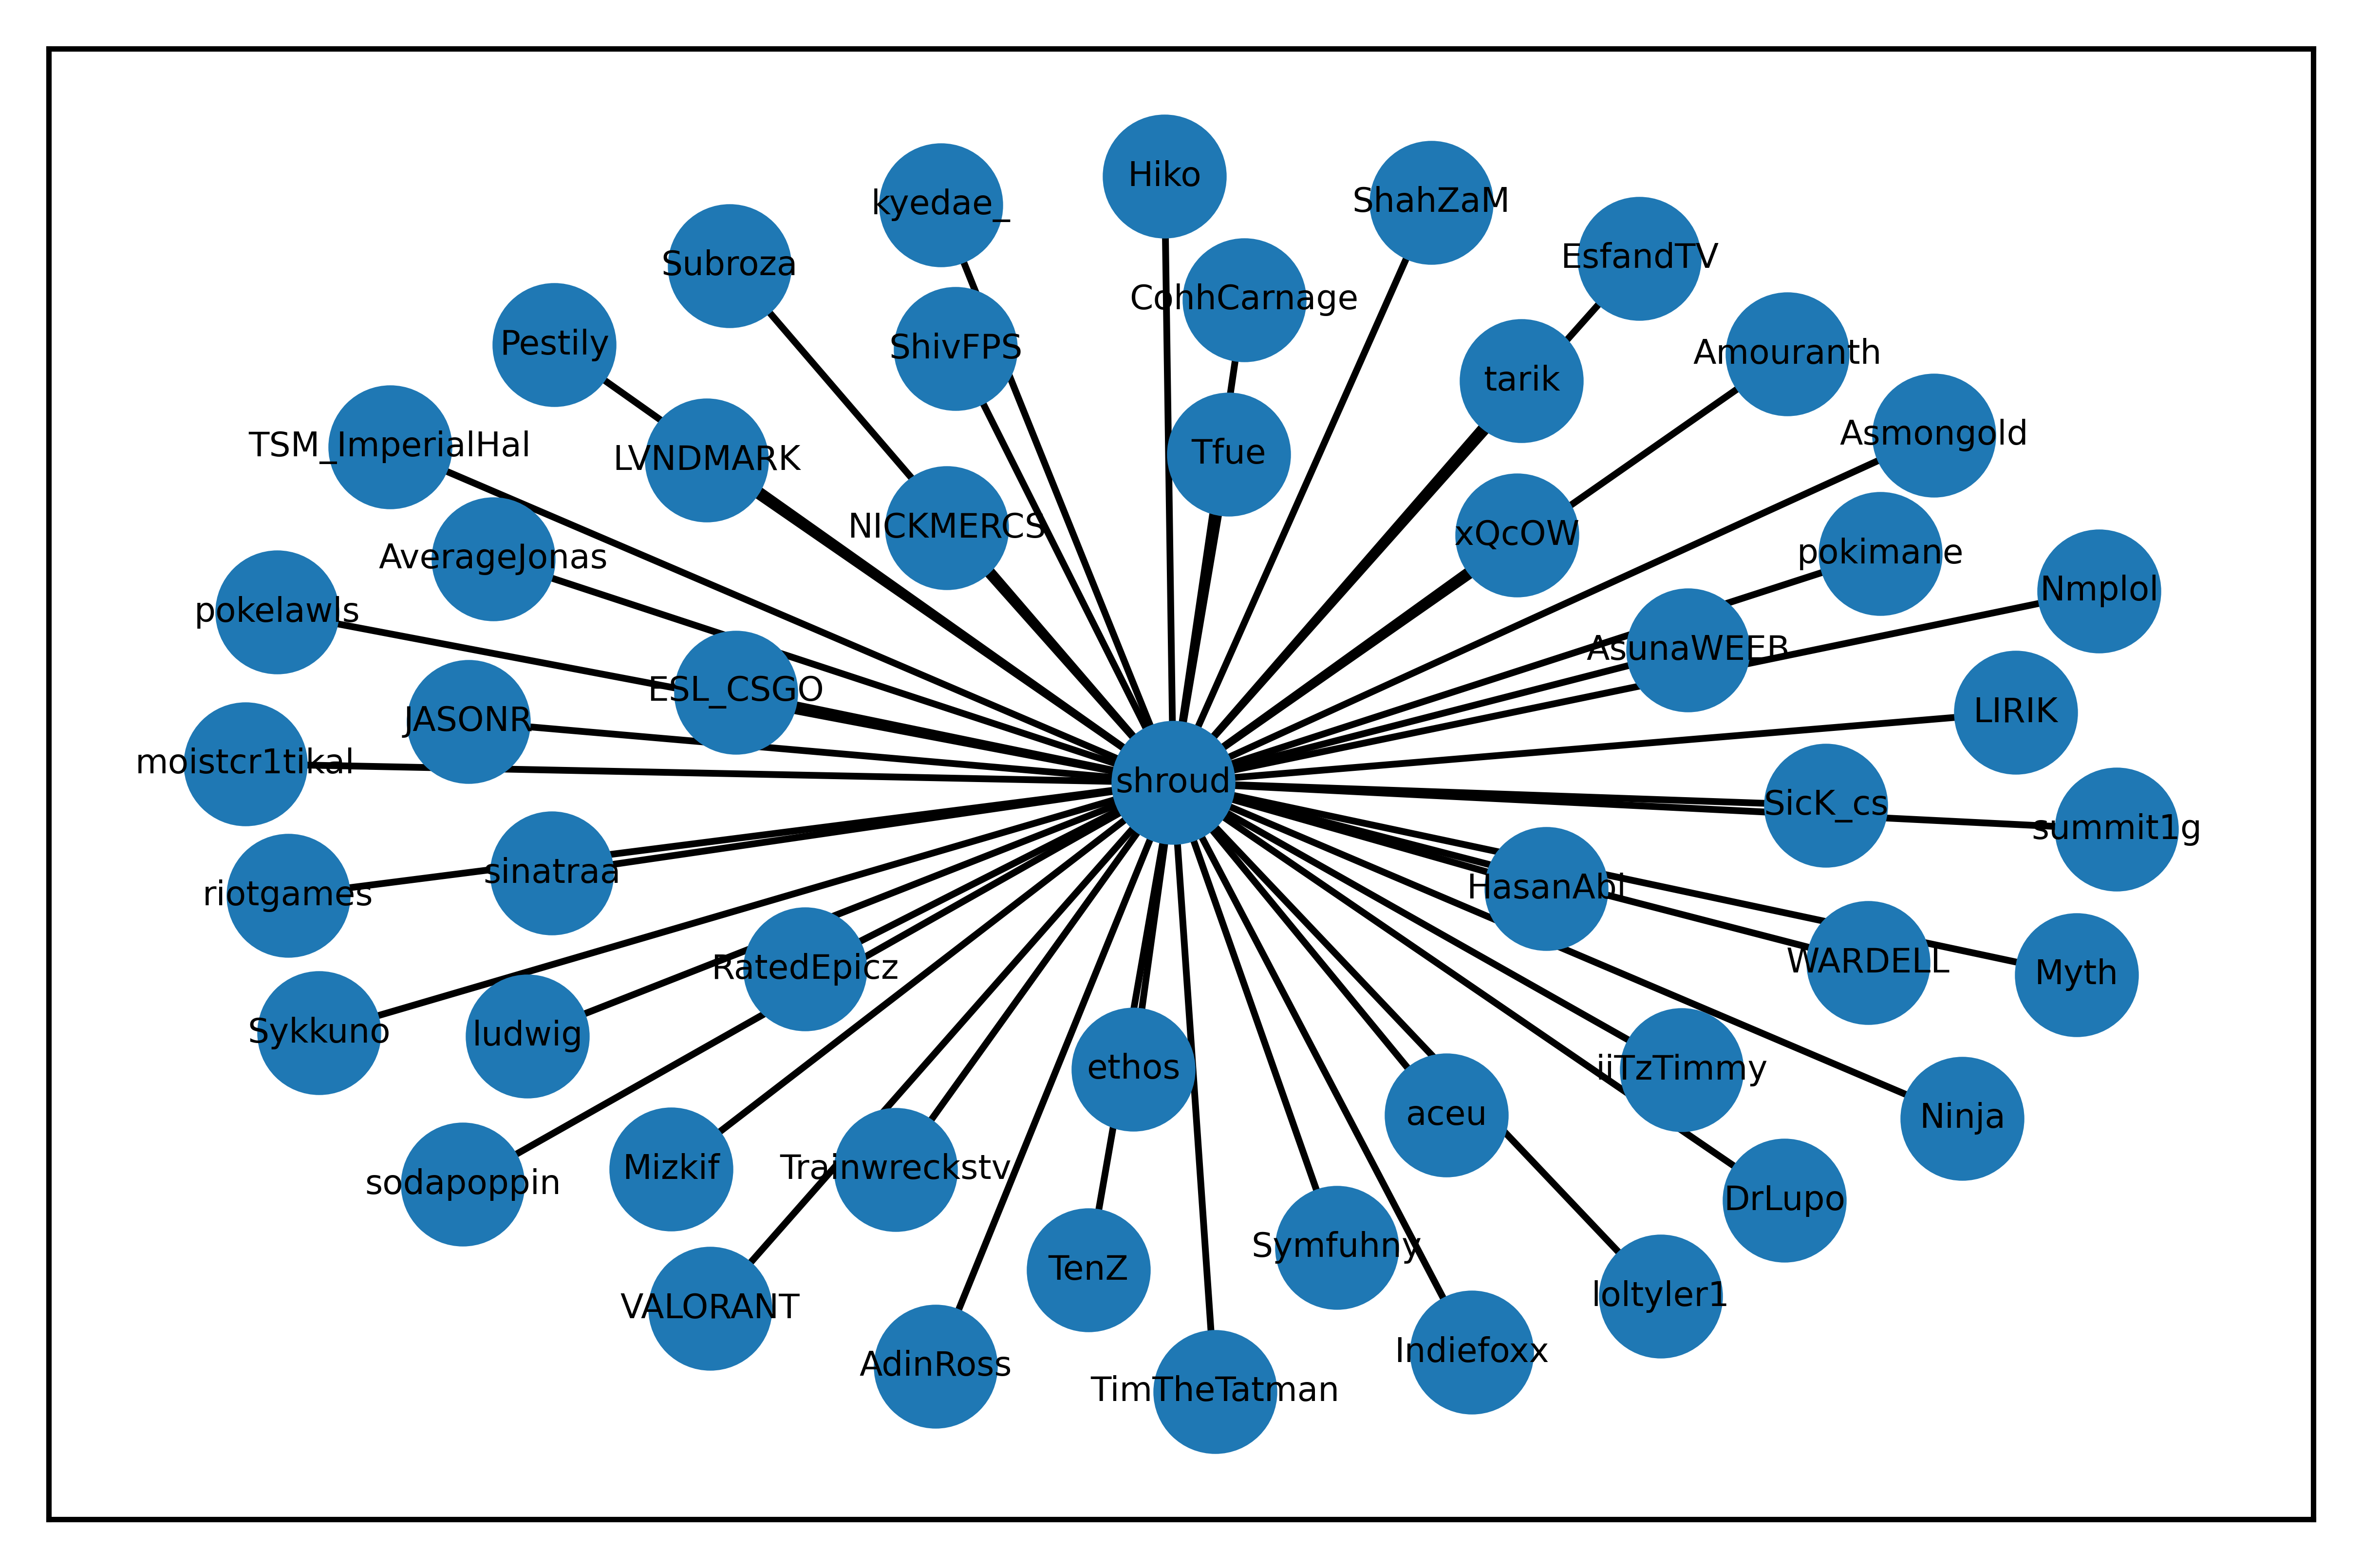

In [54]:
shroud = df_edges.filter((col("Target")  == "shroud") | (col("Source")  == "shroud")).sort(desc("Weight")).limit(50).toPandas()
subgraph = nx.from_pandas_edgelist(shroud, "Source", "Target")
nx.draw_networkx(subgraph, with_labels=True, font_size=5, node_size=300)
plt.rcParams['figure.dpi'] = 1000
plt.show()

In [ ]:
corr = df_top.corr('Followers', 'Peak viewers')
print(corr)
corr = df_top.corr('Followers', 'Watch time(Minutes)')
print(corr)
corr = df_top.corr('Peak viewers', 'Watch time(Minutes)')
print(corr)

In [ ]:
# plt.figure(figsize=(12,8))
# pearsonCorr = Correlation.corr(df_top, 'Followers', 'pearson').collect()[0][0]
# sns.heatmap(pearsonCorr, annot = True)
# plt.title('Relation Heatmap', fontsize = 20)
# plt.show()

standardize the data to have a mean of zero and a standard deviation of one.
#### kmeans

In [ ]:
# cost = np.zeros(20)
# for k in range(2,20):
#     kmeans = KMeans()\
#             .setK(k)\
#             .setSeed(1) \
#             .setFeaturesCol("Weight")\
#             .setPredictionCol("Target")

#     model = kmeans.fit(df_edges)
#     cost[k] = model.computeCost(data) 